In [1]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%load_ext autoreload
%autoreload 2

2023-07-17 15:42:17.455816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
adata = sc.read_h5ad('../EEL_AnnData/EEL_41CleanNuclei-CellularNgh_FeaturesMN.h5ad')


In [10]:
palette = {
    'AC-like':'#2ecc71',#inchworm B4FF9F
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    
    # AC-like 3, MN33 very noisy for NN analysis
    #'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'

    'MES-like 2': '#EDE8F3',
    'MES-like 3': '#E2D8EA',
    'MES-like 1': '#D6BEDD',
    'MES-like 5': '#CFA8D1',
    'MES-like 4': '#CA90C5',
    'MES-like 7': '#D873B6',
    'MES-like 8': '#C50F53',
    'MES-like 6': '#840034',
        
    
    'NPC-like 1':'#FFF192',
    'NPC-like 2':'#FFF192',
    'NPC-like 3':'#FFF192',
    'NPC-like':'#FFF192',
    
    'RG':'#ff9470',
    'RG 1':'#ff9470',
    'RG 2':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    'OPC-like 3':'#89c4f4', #bright turquoise
    'OPC-like':'#89c4f4',
    
    #'Endothelial':'#d5b8ff', #mauve
    'Endothelial 1':'#8c14fc',#'#d5b8ff', #mauve
    'Endothelial':'#8c14fc',#'#d5b8ff', #mauve
    'Mural cell': '#8c14fc',  #electric indigo
    'Mural cell 1': '#8c14fc',  #electric indigo
    'Mural': '#8c14fc',  #electric indigo
    
    'Fibroblast': '#fbe7ef',
    'FB-like 2': '#FF6EC7', #fff9de
    'FB-like 3': '#FF6EC7', #fff9de
     #'FB-like 1': '#FF6EC7', #fff9de

    'Mono 1': '#c8f7c5',#'#e6d9cb',#'#cdd1e4',#'#f4ede4',
    'Mono 2': '#FBFCFA',
    
    'TAM-MDM 1':'#e88474',#'#F5C9B0',
    'TAM-MDM 2':'#A94A54',
    
    'TAM-MDM 3':'#89c4f4',#'#95a5a6',#'#ecd9dd',
    'TAM-MDM 4':'#DC9D57',#'#A5765C',
    
    'TAM-BDM 1':'#e88474',#'#F5C9B0',
    'TAM-BDM 2':'#A94A54',
    
    'TAM-BDM 3':'#89c4f4',#'#95a5a6',#'#ecd9dd',
    'TAM-BDM 4':'#DC9D57',#'#A5765C',
    
    'TAM-MG':'#825e5c', #'#00b5cc' (blue),
    
    'DC': '#a6915c',
}

palette_classes = {
    'GBL-like':'#c2f970',#'#c2f970'
    'AC-like':'#2ecc71',#inchworm B4FF9F
    'preOPC-like':'#7befb2',#'#c2f970'

    #'MES-like': '#EDE8F3',
    'MES-like': '#C50F53',
    'NPC-like':'#FFF192',
    'RG':'#ff9470',
    
    'OPC-like':'#89c4f4',

    'FB-like': '#FF6EC7', #fff9de

}

In [4]:
import pandas as pd
adata.obs['Class'] = pd.Categorical([x.split(' ')[0] for x in adata.obs.CombinedNameMergeImmune])

In [5]:
adata.obs.Class.cat.categories

Index(['AC-like', 'DC', 'Endothelial', 'Erythrocyte', 'FB-like', 'GBL-like',
       'MES-like', 'Mono', 'Mural', 'NPC-like', 'OPC-like', 'Oligodendrocyte',
       'Plasma', 'RG', 'TAM-BDM', 'TAM-MG', 'preOPC-like', 'unknown',
       'unknown2'],
      dtype='object')

In [6]:
adata.obs['CombinedNameMergeTemp'] = pd.Categorical(
    [
        'Endothelial' if x == 7 and cn.count('unknown') else cn for x,cn in zip(adata.obs.MolecularNgh, adata.obs.CombinedNameMergeTemp)
    ]
)



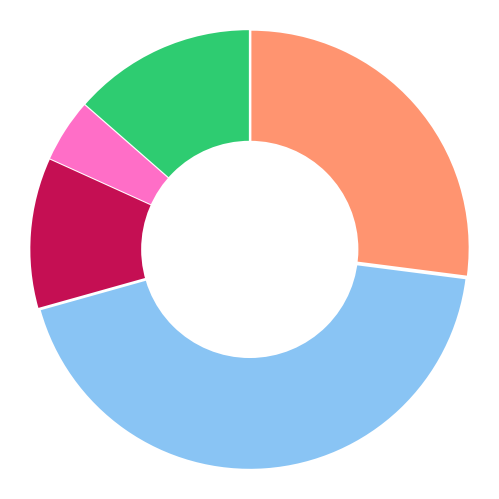

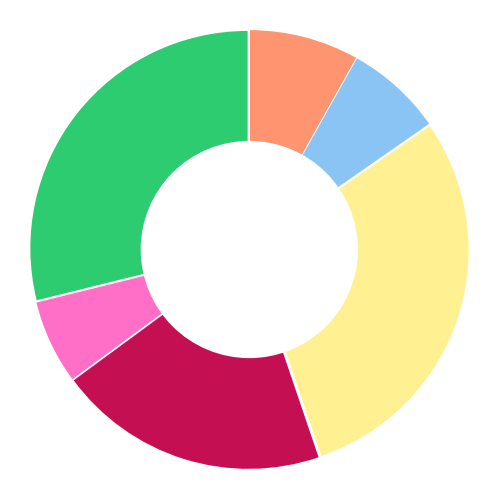

In [7]:
import matplotlib.pyplot as plt
# Pie chart
for s in ['SL023','SL034']:
    sadata = adata[adata.obs.Sample == s]
    sadata = sadata[sadata.X.sum(axis=1)>20]
    
    #df_table = sadata.obs.pivot_table(values='Area', index='Class', aggfunc=np.sum)
    #df_table = df_table.loc[list(palette_classes.keys()),:]
    #p = df_table.Area/df_table.Area.sum() *100
    #df_table = df_table[p > 2.5]
    #classes = df_table.index.values
    #counts = df_table.Area.values
    
    classes, counts = np.unique(sadata.obs['Class'], return_counts=True)
    
    counts = counts[np.isin(classes,  list(palette_classes.keys()))]
    classes = classes[np.isin(classes, list(palette_classes.keys()))]
    
    p = counts/counts.sum() *100 > 1.5
    counts = counts[p]
    classes = classes[p]
    
    

    labels = [c.split('-')[0] for c in classes]
    sizes = counts
    #colors
    colors = [palette_classes[x] for x in classes]
    #explsion
    explode = [0.01 for c in classes]
    fig1, ax1 = plt.subplots(1,1,figsize=(5,5))
    kwargs={'fontsize':16},
    ax1.pie(
        sizes, 
        colors = colors, 
        #labels=labels, 
        #autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85,
        labeldistance=0.75,
        explode = explode,
        textprops={'fontsize': 12}
        #kwargs=**kwargs,
    )
    #draw circle
    centre_circle = plt.Circle((0,0),0.50,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig(f'figures/pie{s}.pdf')
    plt.show()

In [9]:
adata.obs.Class

7-0-0            GBL-like
8-0-0            GBL-like
11-0-0           GBL-like
12-0-0           GBL-like
13-0-0           GBL-like
                   ...   
9063062-21-40     unknown
9063063-21-40     unknown
9063065-21-40     unknown
9063069-21-40     unknown
9063090-21-40     unknown
Name: Class, Length: 6463910, dtype: category
Categories (19, object): ['AC-like', 'DC', 'Endothelial', 'Erythrocyte', ..., 'TAM-MG', 'preOPC-like', 'unknown', 'unknown2']

INFO:root:First filter, 42742 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 20109 cells left
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


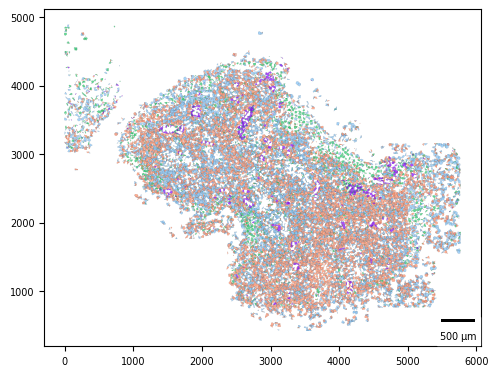

In [20]:

sp.pl.plot_polygons(
    adata,
    sample='SL023',
    palette=palette,
    #geometry_key='Centroid',
    cluster_key= 'Class',
    clusters = ['AC-like','OPC-like','RG','Mural','Endothelial'],
    markersize=.25,
    figsize=(5,5),
    xlim=(3000, 9000),
    ylim=(0,6000),

    show_scalebar=True,
    show_axis=True,
    #save=True,
    #savepath='figures/SL023.svg',
    
)

INFO:root:First filter, 72147 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 2899 cells left
INFO:root:First filter, 2522 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 111 cells left
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


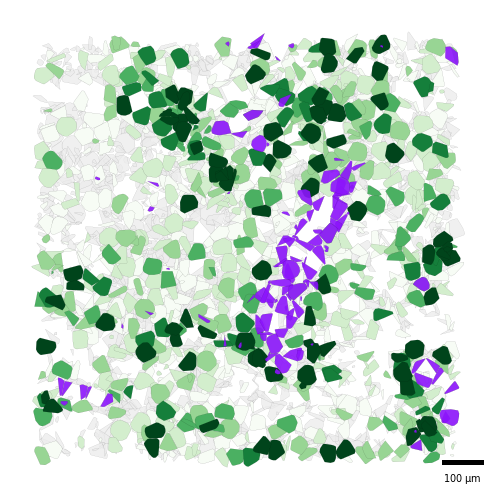

In [23]:
xlim=(5000, 6000)
ylim=(3000,4000)

fig,ax = plt.subplots(1,1 ,figsize=(5,5))
sp.pl.plot_polygons_expression(
    adata,#[adata.obs.Class == 'AC-like'],
    sample='SL023',
    genes=['CRYAB'],
    cmap='Greens',
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    #figsize=(5,5),
    mquant=0.99,
    ax = ax
    #save=True,
    #savepath='figures/SL035B_zoom.svg',
)

sp.pl.plot_polygons(
    adata,
    sample='SL023',
    cluster_key='CombinedNameMergeTemp',
    clusters=['Mural','Endothelial'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=0.9,
    show_axis=True,
    palette= {'Endothelial':'#8c14fc',  'Mural': '#8c14fc'},
    ax=ax,
)

plt.savefig('figures/CRYAB_SL023.svg',dpi=300, format='svg', transparent=True,bbox_inches='tight')

INFO:root:First filter, 72147 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 31292 cells left


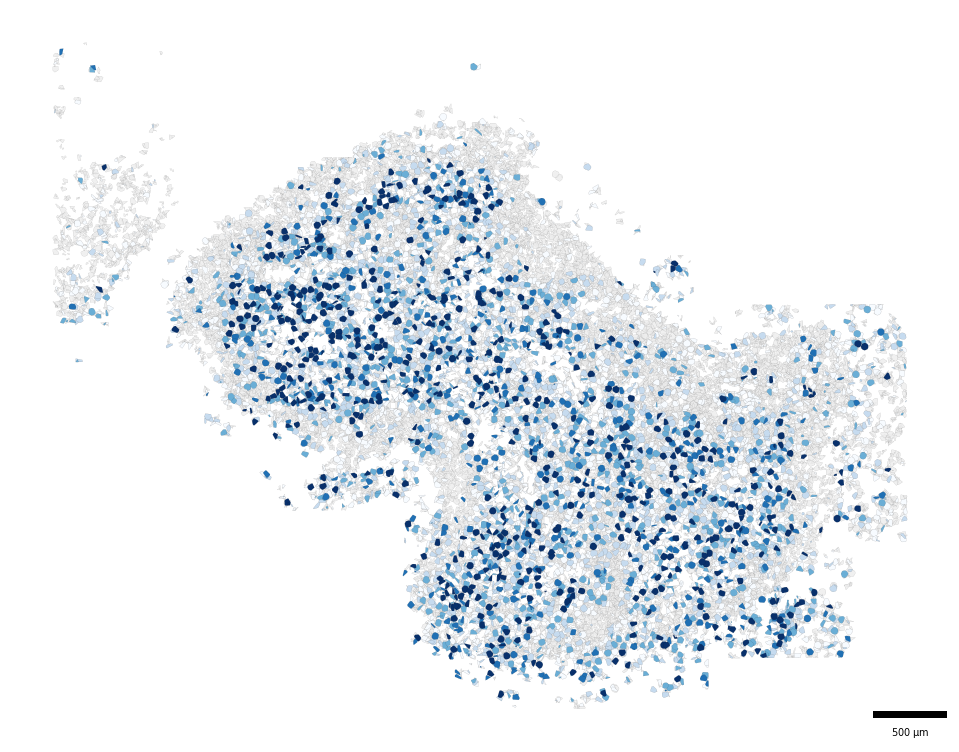

In [24]:
xlim=(3000, 9000)
ylim=(0,6000)

sp.pl.plot_polygons_expression(
    adata,#[adata.obs.Class == 'AC-like'],
    sample='SL023',
    genes=['CDK4'],
    cmap='Blues',
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    #figsize=(5,5),
    mquant=0.99,
    save=True,
    savepath='figures/SL023_CDK4.svg',
)

# MDM2 - NPC

In [ ]:
sp.pl.plot_polygons(
    adata,
    sample='SL034',
    palette=palette,
    #geometry_key='Centroid',
    cluster_key= 'Class',
    clusters = ['AC-like','OPC-like','RG','NPC-like','Mural','Endothelial'],
    alpha=1.0,
    figsize=(5,5),
    xlim=(9000, 17500),
    ylim=(0,5000),

    show_scalebar=True,
    show_axis=False,
    save=True,
    savepath='figures/SL034.svg',
    
)

INFO:root:First filter, 45550 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 22333 cells left
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


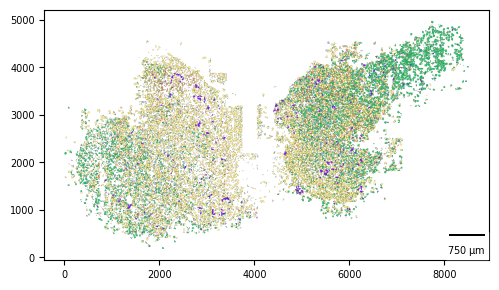

In [31]:
sp.pl.plot_polygons(
    adata,
    sample='SL034',
    palette=palette,
    #geometry_key='Centroid',
    cluster_key= 'Class',
    clusters = ['AC-like','OPC-like','RG','NPC-like','Mural','Endothelial'],
    alpha=1.0,
    figsize=(5,5),
    xlim=(9000, 17500),
    ylim=(0,5000),

    show_scalebar=True,
    show_axis=True, 
    
)

INFO:root:First filter, 117042 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 3833 cells left
INFO:root:First filter, 1337 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 43 cells left
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


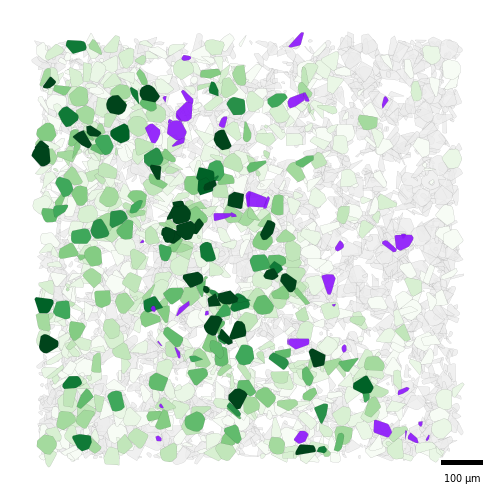

In [49]:
xlim=(11500, 12500)
ylim=(2000,3000)

fig,ax = plt.subplots(1,1 ,figsize=(5,5))
sp.pl.plot_polygons_expression(
    adata,#[adata.obs.Class == 'AC-like'],
    sample='SL034',
    genes=['CRYAB'],
    cmap='Greens',
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    #figsize=(5,5),
    mquant=0.99,
    ax = ax,
    bgval=1,
    #save=True,
    #savepath='figures/SL035B_zoom.svg',
)

sp.pl.plot_polygons(
    adata,
    sample='SL034',
    cluster_key='CombinedNameMergeTemp',
    clusters=['Mural','Endothelial'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=0.9,
    show_axis=True,
    palette= {'Endothelial':'#8c14fc',  'Mural': '#8c14fc',},
    ax=ax,
)

plt.savefig('figures/CRYAB_SL034.svg',dpi=300, format='svg', transparent=True,bbox_inches='tight')

INFO:root:First filter, 117042 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 61274 cells left


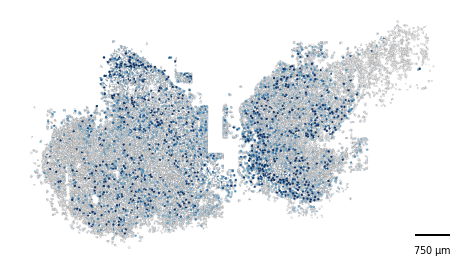

In [34]:
xlim=(9000, 17500)
ylim=(0,5000)


sp.pl.plot_polygons_expression(
    adata,#[adata.obs.Class == 'AC-like'],
    sample='SL034',
    genes=['MDM2'],
    cmap='Blues',
    #cluster_key='CombinedNameMerge',
    #clusters= ['MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8'], #[45,76],
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    #figsize=(5,5),
    figsize=(5,5),
    mquant=0.99,
    save=True,
    savepath='figures/SL034_MDM2.svg',
)